**STEP 0: SETUP & DATA LOADING**

In [ ]:
from google.colab import drive
import pandas as pd

drive.mount('/content/drive')
file_path = '/content/drive/My Drive/WIA1007/carlist_scraped_data.csv'

df = pd.read_csv(file_path)
display(df.head())


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Description,Monthly_Installment,List_Price,Model,Mileage,Gear_Type,Location
0,2021 Toyota Hilux 2.4 E Dual Cab Pickup - UNDE...,RM 983 / month,"RM 75,800",Toyota Hilux,115 - 120K KM,Automatic,"Kuala Lumpur, Batu Caves / Selayang"
1,2019 Toyota Vios 1.5 G Sedan - (A) FACELIFT NS...,RM 607 / month,"RM 46,800",Toyota Vios,55 - 60K KM,Automatic,"Selangor, Seri Kembangan"
2,2013 Nissan Almera 1.5 E Sedan - impul,RM 231 / month,"RM 17,790",Nissan Almera,155 - 160K KM,Automatic,"Selangor, Banting"
3,2017 Perodua Myvi 1.5 AV Hatchback - Adv,RM 425 / month,"RM 32,800",Perodua Myvi,90 - 95K KM,Automatic,"Kuala Lumpur, Setapak"
4,2018/2019 BMW X5 2.0 xDrive40e M Sport SUV - Y...,"RM 1,283 / month","RM 99,000",BMW X5,70 - 75K KM,Automatic,"Selangor, Petaling Jaya"


In [ ]:
df.tail()

,Description,Monthly_Installment,List_Price,Model,Mileage,Gear_Type,Location
3995,2011 Peugeot RCZ 1.6 Coupe - (A) LOW MILEAGE 2...,RM 516 / month,"RM 39,800",Peugeot RCZ,40 - 45K KM,Automatic,"Perak, Ipoh"
3996,2025 BMW 750e 3.0 xDrive M Sport Pure Excellen...,"RM 6,337 / month","RM 488,800",BMW 750e,5 - 10K KM,Automatic,"Kuala Lumpur, Jalan Kuching"
3997,2015 Honda City 1.5 S Plus Sedan,RM 446 / month,"RM 34,400",Honda City,135 - 140K KM,Automatic,"Perak, Ipoh"
3998,2024 Perodua Ativa 1.0 AV SUV - (A) F Service ...,RM 736 / month,"RM 56,800",Perodua Ativa,30 - 35K KM,Automatic,"Perak, Sitiawan"
3999,2017 Honda BR-V 1.5 V SUV - (A) 3 YEARS WARRAN...,RM 465 / month,"RM 35,868",Honda BR-V,80 - 85K KM,Automatic,"Kuala Lumpur, Sentul"


In [ ]:
df.columns

Index(['Description', 'Monthly_Installment', 'List_Price', 'Model', 'Mileage',
       'Gear_Type', 'Location'],
      dtype='object')

In [ ]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Description          4000 non-null   object
 1   Monthly_Installment  4000 non-null   object
 2   List_Price           3999 non-null   object
 3   Model                4000 non-null   object
 4   Mileage              4000 non-null   object
 5   Gear_Type            4000 non-null   object
 6   Location             4000 non-null   object
dtypes: object(7)
memory usage: 218.9+ KB


,Description,Monthly_Installment,List_Price,Model,Mileage,Gear_Type,Location
count,4000,4000,3999,4000,4000,4000,4000
unique,3472,1038,1301,307,460,2,109
top,2018 Proton Preve 1.6 CFE Premium Sedan - Full...,RM 516 / month,"RM 39,800",Perodua Myvi,85 - 90K KM,Automatic,"Selangor, Petaling Jaya"
freq,21,37,36,243,260,3910,257


**STEP 1: DATA PREPROCESSING**

In [ ]:
# --- BLOCK 1: Remove the redundant Monthly_Installment ---
import pandas as pd
import numpy as np
import re

if 'Monthly_Installment' in df.columns:
    df.drop(columns=['Monthly_Installment'], inplace=True)

df_clean = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Description  4000 non-null   object
 1   List_Price   3999 non-null   object
 2   Model        4000 non-null   object
 3   Mileage      4000 non-null   object
 4   Gear_Type    4000 non-null   object
 5   Location     4000 non-null   object
dtypes: object(6)
memory usage: 187.6+ KB


In [ ]:
# --- BLOCK 2: CLEAN PRICE ---
# Logic: Handle various price formats including discounts (-X% RM XX,XXX)
# and filter out invalid scrapped entries like "X days Y hours"

import re

def parse_price(val):

    if pd.isna(val):
        return None

    s = str(val).strip()

    # Check for invalid time-based entries (e.g., "2 days 22 hours", "1 hours")
    if re.search(r'\d+\s*(day|hour|minute|second)', s, re.IGNORECASE):
        return None

    # Pattern 1: Price with discount prefix like "-X% RM XX,XXX"
    # This extracts the RM amount after the percentage
    match = re.search(r'RM\s*([\d,]+)', s, re.IGNORECASE)
    if match:
        price_str = match.group(1).replace(',', '')
        try:
            return float(price_str)
        except:
            return None

    # Pattern 2: Just numbers with commas (no RM prefix)
    clean_val = s.replace(',', '').replace('RM', '').strip()
    try:
        return float(clean_val)
    except:
        return None

# Apply the parsing function
df_clean['Price'] = df_clean['List_Price'].apply(parse_price)


# Count successful vs failed extractions
total_rows = len(df_clean)
successful = df_clean['Price'].notna().sum()
failed = df_clean['Price'].isna().sum()

print(f"\nSummary:")
print(f"   Total rows: {total_rows}")
print(f"   Successfully parsed: {successful} ")
print(f"   Failed to parse: {failed} ")

# Show examples of failed extractions
if failed > 0:
    print(f"\nSample of UNPARSEABLE prices:")
    failed_samples = df_clean[df_clean['Price'].isna()]['List_Price'].unique()[:20]
    for i, sample in enumerate(failed_samples, 1):
        print(f"   {i}. '{sample}'")

# Show examples of successful extractions with various formats
print(f"\nSample of SUCCESSFUL price extractions:")
sample_df = df_clean[df_clean['Price'].notna()][['List_Price', 'Price']].drop_duplicates().head(10)
print(sample_df.to_string(index=False))


Summary:
   Total rows: 4000
   Successfully parsed: 3973 
   Failed to parse: 27 

Sample of UNPARSEABLE prices:
   1. '4 days 21 hours'
   2. '3 days 22 hours'
   3. '1 hours'
   4. '2 days 22 hours'
   5. '3 days 4 hours'
   6. '2 days 23 hours'
   7. '4 days 10 hours'
   8. 'nan'
   9. '4 days 23 hours'
   10. '5 days 2 hours'
   11. '8 days 5 hours'
   12. '6 days'

Sample of SUCCESSFUL price extractions:
List_Price    Price
 RM 75,800  75800.0
 RM 46,800  46800.0
 RM 17,790  17790.0
 RM 32,800  32800.0
 RM 99,000  99000.0
 RM 52,800  52800.0
RM 149,000 149000.0
 RM 83,333  83333.0
 RM 58,800  58800.0
 RM 61,800  61800.0


In [ ]:
df.head()

,Description,List_Price,Model,Mileage,Gear_Type,Location
0,2021 Toyota Hilux 2.4 E Dual Cab Pickup - UNDE...,"RM 75,800",Toyota Hilux,115 - 120K KM,Automatic,"Kuala Lumpur, Batu Caves / Selayang"
1,2019 Toyota Vios 1.5 G Sedan - (A) FACELIFT NS...,"RM 46,800",Toyota Vios,55 - 60K KM,Automatic,"Selangor, Seri Kembangan"
2,2013 Nissan Almera 1.5 E Sedan - impul,"RM 17,790",Nissan Almera,155 - 160K KM,Automatic,"Selangor, Banting"
3,2017 Perodua Myvi 1.5 AV Hatchback - Adv,"RM 32,800",Perodua Myvi,90 - 95K KM,Automatic,"Kuala Lumpur, Setapak"
4,2018/2019 BMW X5 2.0 xDrive40e M Sport SUV - Y...,"RM 99,000",BMW X5,70 - 75K KM,Automatic,"Selangor, Petaling Jaya"


In [ ]:
# --- BLOCK 3: CLEAN MILEAGE ---

def parse_mileage(val):
    if pd.isna(val): return None
    s = str(val).upper().replace('KM', '').strip()

    # Case 1: Range (e.g., "110 - 115K")
    if '-' in s:
        try:
            parts = s.split('-')
            # Remove 'K' from both sides, convert to float
            low = float(parts[0].replace('K', '').strip())
            high = float(parts[1].replace('K', '').strip())
            # Average them and multiply by 1000
            return (low + high) / 2 * 1000
        except:
            return None

    # Case 2: Definitive Value (e.g., "95965" OR "115K")
    try:
        clean_val = float(s.replace('K', ''))
        # If it had a 'K', multiply by 1000. If it was "95965", keep as is.
        if 'K' in s:
            return clean_val * 1000
        return clean_val
    except:
        return None

df_clean['Mileage'] = df_clean['Mileage'].apply(parse_mileage)

# Check results
print(df_clean[['Description', 'Mileage']].head())
display(df_clean['Mileage'].isna().sum())

                                         Description   Mileage
0  2021 Toyota Hilux 2.4 E Dual Cab Pickup - UNDE...  117500.0
1  2019 Toyota Vios 1.5 G Sedan - (A) FACELIFT NS...   57500.0
2             2013 Nissan Almera 1.5 E Sedan - impul  157500.0
3           2017 Perodua Myvi 1.5 AV Hatchback - Adv   92500.0
4  2018/2019 BMW X5 2.0 xDrive40e M Sport SUV - Y...   72500.0


np.int64(0)

In [ ]:
display(df_clean.head())

,Description,List_Price,Model,Mileage,Gear_Type,Location,Price
0,2021 Toyota Hilux 2.4 E Dual Cab Pickup - UNDE...,"RM 75,800",Toyota Hilux,117500.0,Automatic,"Kuala Lumpur, Batu Caves / Selayang",75800.0
1,2019 Toyota Vios 1.5 G Sedan - (A) FACELIFT NS...,"RM 46,800",Toyota Vios,57500.0,Automatic,"Selangor, Seri Kembangan",46800.0
2,2013 Nissan Almera 1.5 E Sedan - impul,"RM 17,790",Nissan Almera,157500.0,Automatic,"Selangor, Banting",17790.0
3,2017 Perodua Myvi 1.5 AV Hatchback - Adv,"RM 32,800",Perodua Myvi,92500.0,Automatic,"Kuala Lumpur, Setapak",32800.0
4,2018/2019 BMW X5 2.0 xDrive40e M Sport SUV - Y...,"RM 99,000",BMW X5,72500.0,Automatic,"Selangor, Petaling Jaya",99000.0


In [ ]:
# --- BLOCK 4: EXTRACT YEAR ---

# ^      = Start of string
# \d{4}  = Exactly 4 digits (e.g., 2015)
df_clean['Year'] = df_clean['Description'].astype(str).str.extract(r'^(\d{4})').astype(float)

# Check results (Ensure 2015/2018 becomes 2015)
print(df_clean[['Description', 'Year']].head())

# Check for missing values in Year after extraction
display(df_clean['Year'].isna().sum())

                                         Description    Year
0  2021 Toyota Hilux 2.4 E Dual Cab Pickup - UNDE...  2021.0
1  2019 Toyota Vios 1.5 G Sedan - (A) FACELIFT NS...  2019.0
2             2013 Nissan Almera 1.5 E Sedan - impul  2013.0
3           2017 Perodua Myvi 1.5 AV Hatchback - Adv  2017.0
4  2018/2019 BMW X5 2.0 xDrive40e M Sport SUV - Y...  2018.0


np.int64(0)

In [ ]:
# --- BLOCK 5: EXTRACT BRAND ---

def extract_brand(desc):
    if pd.isna(desc): return pd.NA

    # 1. Remove the Year(s) at the start
    # Matches "2015 " or "2015/2019 "
    # ^ = Start, \d{4} = Year, (/\d{4})? = Optional second year
    clean_desc = re.sub(r'^\d{4}(/\d{4})?\s+', '', str(desc)).strip()

    # 2. Split into words
    words = clean_desc.split()
    if not words: return pd.NA

    # 3. Handle Multi-word Brands (Specific exceptions)
    # Most brands are 1 word (Toyota, BMW). Mercedes-Benz is 1 word (hyphenated).
    # Land Rover is the main 2-word exception in Malaysia.
    if len(words) >= 2:
        first_two = f"{words[0]} {words[1]}"
        if first_two.lower() in ['land rover', 'alfa romeo', 'aston martin']:
            return first_two

    # 4. Default: Take the first word
    return words[0]

# Apply extraction
df_clean['Brand'] = df_clean['Description'].apply(extract_brand)

# Quick sanity check
print("Top 30 Brands Found:")
print(df_clean['Brand'].value_counts().head(30))

# Check for any weird extraction errors (brands appearing only once)
print("\nRare/Weird Brands (Check for errors):")
print(df_clean['Brand'].value_counts().tail(5))
display(df_clean['Year'].isna().sum())

Top 30 Brands Found:
Brand
Honda            699
Toyota           656
Perodua          614
BMW              463
Mercedes-Benz    343
Proton           317
Nissan           175
Mazda            152
Volkswagen        84
Ford              63
MINI              59
Porsche           55
Mitsubishi        44
Volvo             41
Hyundai           28
Kia               23
Peugeot           22
Lexus             21
Isuzu             21
Land Rover        20
Daihatsu          19
Subaru            13
Audi              13
Bentley            9
BYD                8
Suzuki             6
Lamborghini        4
Ferrari            4
Chery              3
Maserati           3
Name: count, dtype: int64

Rare/Weird Brands (Check for errors):
Brand
Austin         1
Foton          1
Rolls-Royce    1
JAECOO         1
Chrysler       1
Name: count, dtype: int64


np.int64(0)

In [ ]:
# --- BLOCK 6: EXTRACT ENGINE CAPACITY ---

def extract_engine(desc):
    if pd.isna(desc): return None

    # Regex Logic:
    # \b      = Word boundary (ensures we don't catch part of a number)
    # \d\.\d  = Digit + Dot + Digit (e.g., 1.5, 2.0, 3.0)
    # \b      = Word boundary
    match = re.search(r'\b(\d\.\d)\b', str(desc))

    if match:
        return float(match.group(0))
    return None

df_clean['Engine_L'] = df_clean['Description'].apply(extract_engine)

# Sanity Check
print("Common Engine Sizes:")
print(df_clean['Engine_L'].value_counts().head(10))

# Check for missing values (Some descriptions might miss this info)
missing_engine = df_clean['Engine_L'].isna().sum()
print(f"\nRows with missing Engine Capacity: {missing_engine}")

display(df_clean[df_clean['Engine_L'].isna()])

Common Engine Sizes:
Engine_L
1.5    1144
2.0    1115
1.8     263
1.6     261
1.3     235
2.5     232
1.0     189
2.4     125
3.0     116
1.4      46
Name: count, dtype: int64

Rows with missing Engine Capacity: 9


,Description,List_Price,Model,Mileage,Gear_Type,Location,Price,Year,State,Brand,Origin,Engine_L
95,2023 BMW iX xDrive50 Sport SUV - Sime Darby Au...,"RM 278,000",BMW iX,27500.0,Automatic,"Selangor, Shah Alam",278000.0,2023.0,Selangor,BMW,Continental,NaN
186,2024 MINI Countryman SE ALL4 SUV - Sime Darby ...,"RM 190,888",MINI Countryman,12500.0,Automatic,"Selangor, Shah Alam",190888.0,2024.0,Selangor,MINI,Continental,NaN
715,2025 BYD Atto 3 Ultra Extended Range SUV - SIS...,"RM 99,999",BYD Atto 3,2500.0,Automatic,"Kuala Lumpur, Sungai Besi",99999.0,2025.0,Kuala Lumpur,BYD,Asian,NaN
886,2024 BMW i5 eDrive40 M Sport Sedan,"RM 273,800",BMW i5,22500.0,Automatic,"Kuala Lumpur, Jalan Kuching",273800.0,2024.0,Kuala Lumpur,BMW,Continental,NaN
1707,2025 BMW i4 eDrive35 Coupe - LCI- Special Deals,"RM 230,000",BMW i4,2500.0,Automatic,"Kedah, Alor Setar",230000.0,2025.0,Kedah,BMW,Continental,NaN
2319,2025 Volvo EX90 Ultra Twin SUV - Flagship Luxu...,5 days 2 hours,Volvo EX90,2500.0,Automatic,"Perak, Ipoh",NaN,2025.0,Perak,Volvo,Continental,NaN
3183,2023 BMW iX xDrive40 Sport SUV - 40 Sport I20 ...,"RM 235,000",BMW iX,32500.0,Automatic,"Selangor, Petaling Jaya",235000.0,2023.0,Selangor,BMW,Continental,NaN
3986,2023/2024 BYD Dolphin Dynamic Hatchback - SISM...,"RM 77,000",BYD Dolphin,7500.0,Automatic,"Kuala Lumpur, Sungai Besi",77000.0,2023.0,Kuala Lumpur,BYD,Asian,NaN
3988,2025 BYD Atto 3 Ultra Extended Range SUV - SIS...,"RM 99,999",BYD Atto 3,2500.0,Automatic,"Kuala Lumpur, Sungai Besi",99999.0,2025.0,Kuala Lumpur,BYD,Asian,NaN


In [ ]:
# --- BLOCK 7: CLEAN STATE ---
# Logic: "Selangor, Puchong" -> Split by comma -> "Selangor"

df_clean['State'] = df_clean['Location'].astype(str).str.split(',').str[0].str.strip()

# Check unique states to ensure no messy data
print("States Found:", df_clean['State'].unique())

States Found: ['Kuala Lumpur' 'Selangor' 'Perak' 'Terengganu' 'Johor' 'Kedah'
 'Negeri Sembilan' 'Penang' 'Kelantan' 'Pahang' 'Melaka' 'Sabah' 'Perlis'
 'Sarawak' 'Putrajaya']


In [ ]:
df_clean.head()

,Description,List_Price,Model,Mileage,Gear_Type,Location,Price,Year,State,Brand
0,2021 Toyota Hilux 2.4 E Dual Cab Pickup - UNDE...,"RM 75,800",Toyota Hilux,117500.0,Automatic,"Kuala Lumpur, Batu Caves / Selayang",75800.0,2021.0,Kuala Lumpur,Toyota
1,2019 Toyota Vios 1.5 G Sedan - (A) FACELIFT NS...,"RM 46,800",Toyota Vios,57500.0,Automatic,"Selangor, Seri Kembangan",46800.0,2019.0,Selangor,Toyota
2,2013 Nissan Almera 1.5 E Sedan - impul,"RM 17,790",Nissan Almera,157500.0,Automatic,"Selangor, Banting",17790.0,2013.0,Selangor,Nissan
3,2017 Perodua Myvi 1.5 AV Hatchback - Adv,"RM 32,800",Perodua Myvi,92500.0,Automatic,"Kuala Lumpur, Setapak",32800.0,2017.0,Kuala Lumpur,Perodua
4,2018/2019 BMW X5 2.0 xDrive40e M Sport SUV - Y...,"RM 99,000",BMW X5,72500.0,Automatic,"Selangor, Petaling Jaya",99000.0,2018.0,Selangor,BMW


In [ ]:
# --- BLOCK 8: DETERMINE ORIGIN ---

def classify_origin_from_brand(brand):
    brand = str(brand).lower()

    # Define Continental Brands
    # Since we extracted "Brand" cleanly, we can match exact words
    conti_list = [
        'bmw', 'mercedes-benz', 'audi', 'volkswagen', 'volvo', 'peugeot',
        'land rover', 'mini', 'ford', 'porsche', 'jaguar', 'renault',
        'citroen', 'ferrari', 'lamborghini', 'maserati', 'fiat',
        'bentley', 'rolls-royce', 'austin'
    ]

    if brand in conti_list:
        return 'Continental'
    else:
        # Default to Asian (Toyota, Honda, Proton, Perodua, etc.)
        # This covers Inokom, Naza, etc. as well.
        return 'Asian'

df_clean['Origin'] = df_clean['Brand'].apply(classify_origin_from_brand)

print(df_clean['Origin'].value_counts())

Origin
Asian          2815
Continental    1185
Name: count, dtype: int64


In [ ]:
df_clean.head()

,Description,List_Price,Model,Mileage,Gear_Type,Location,Price,Year,State,Brand,Origin
0,2021 Toyota Hilux 2.4 E Dual Cab Pickup - UNDE...,"RM 75,800",Toyota Hilux,117500.0,Automatic,"Kuala Lumpur, Batu Caves / Selayang",75800.0,2021.0,Kuala Lumpur,Toyota,Asian
1,2019 Toyota Vios 1.5 G Sedan - (A) FACELIFT NS...,"RM 46,800",Toyota Vios,57500.0,Automatic,"Selangor, Seri Kembangan",46800.0,2019.0,Selangor,Toyota,Asian
2,2013 Nissan Almera 1.5 E Sedan - impul,"RM 17,790",Nissan Almera,157500.0,Automatic,"Selangor, Banting",17790.0,2013.0,Selangor,Nissan,Asian
3,2017 Perodua Myvi 1.5 AV Hatchback - Adv,"RM 32,800",Perodua Myvi,92500.0,Automatic,"Kuala Lumpur, Setapak",32800.0,2017.0,Kuala Lumpur,Perodua,Asian
4,2018/2019 BMW X5 2.0 xDrive40e M Sport SUV - Y...,"RM 99,000",BMW X5,72500.0,Automatic,"Selangor, Petaling Jaya",99000.0,2018.0,Selangor,BMW,Continental


In [ ]:
# --- BLOCK 9: REVIEW EXTRACTED FEATURES ---

cols_to_check = ['Description', 'Brand', 'Origin', 'Engine_L']
display(df_clean[cols_to_check].sample(5))

,Description,Brand,Origin,Engine_L
3638,2020 Proton X70 1.8 Premium SUV - 65180KM,Proton,Asian,1.8
2788,2017/2022 Mercedes-Benz CLA180 1.6 AMG Coupe -...,Mercedes-Benz,Continental,1.6
2933,2021 Honda Civic 1.5 TC Sedan - (Warranty unde...,Honda,Asian,1.5
3129,2015 Toyota Hilux 2.5 G VNT Dual Cab (Metallic...,Toyota,Asian,2.5
1683,2018 Toyota Vellfire 2.5 ZG MPV - Modellista F...,Toyota,Asian,2.5


In [ ]:
# --- CHECK FOR REMAINING MISSING VALUES ---
print("Current missing values per column:")
print(df_clean.isna().sum())

# --- DROP ROWS WITH ANY REMAINING MISSING VALUES ---
initial_rows = len(df_clean)
df_clean.dropna(inplace=True)
rows_dropped = initial_rows - len(df_clean)

print(f"\nDropped {rows_dropped} rows with missing values.")
print(f"Total rows remaining: {len(df_clean)}")

print("\nMissing values after dropping NaNs:")
print(df_clean.isna().sum())

Current missing values per column:
Description     0
List_Price      1
Model           0
Mileage         0
Gear_Type       0
Location        0
Price          27
Year            0
State           0
Brand           0
Origin          0
Engine_L        9
dtype: int64

Dropped 35 rows with missing values.
Total rows remaining: 3965

Missing values after dropping NaNs:
Description    0
List_Price     0
Model          0
Mileage        0
Gear_Type      0
Location       0
Price          0
Year           0
State          0
Brand          0
Origin         0
Engine_L       0
dtype: int64


In [ ]:
print(df_clean['Model'].value_counts().head(20))
print(df_clean['State'].value_counts().head(20))

Model
Perodua Myvi          236
Honda City            189
Honda Civic           165
Toyota Vios           143
Perodua AXIA           96
Honda HR-V             94
Perodua Bezza          87
Perodua Alza           87
Honda CR-V             85
Toyota Vellfire        82
Toyota Alphard         71
Mazda CX-5             67
BMW X5                 63
BMW 320i               61
Proton X70             61
Toyota Camry           61
Toyota Hilux           54
Ford Ranger            54
Honda Jazz             53
Mercedes-Benz C200     53
Name: count, dtype: int64
State
Selangor           1410
Kuala Lumpur       1268
Johor               339
Perak               280
Penang              212
Negeri Sembilan     118
Pahang               67
Melaka               47
Kelantan             34
Sabah                30
Terengganu           30
Kedah                23
Sarawak              19
Perlis                1
Putrajaya             1
Name: count, dtype: int64


In [ ]:
# --- STEP 1.1: DATA TRANSFORMATION ---
import numpy as np

# 1. Transform 'Car_Age'
df_clean['Car_Age'] = 2025 - df_clean['Year']

df_clean.head(5)


,Description,List_Price,Model,Mileage,Gear_Type,Location,Price,Year,State,Brand,Origin,Engine_L,Car_Age
0,2021 Toyota Hilux 2.4 E Dual Cab Pickup - UNDE...,"RM 75,800",Toyota Hilux,117500.0,Automatic,"Kuala Lumpur, Batu Caves / Selayang",75800.0,2021.0,Kuala Lumpur,Toyota,Asian,2.4,4.0
1,2019 Toyota Vios 1.5 G Sedan - (A) FACELIFT NS...,"RM 46,800",Toyota Vios,57500.0,Automatic,"Selangor, Seri Kembangan",46800.0,2019.0,Selangor,Toyota,Asian,1.5,6.0
2,2013 Nissan Almera 1.5 E Sedan - impul,"RM 17,790",Nissan Almera,157500.0,Automatic,"Selangor, Banting",17790.0,2013.0,Selangor,Nissan,Asian,1.5,12.0
3,2017 Perodua Myvi 1.5 AV Hatchback - Adv,"RM 32,800",Perodua Myvi,92500.0,Automatic,"Kuala Lumpur, Setapak",32800.0,2017.0,Kuala Lumpur,Perodua,Asian,1.5,8.0
4,2018/2019 BMW X5 2.0 xDrive40e M Sport SUV - Y...,"RM 99,000",BMW X5,72500.0,Automatic,"Selangor, Petaling Jaya",99000.0,2018.0,Selangor,BMW,Continental,2.0,7.0


In [ ]:
# Identify duplicate rows
duplicate_rows = df_clean[df_clean.duplicated(keep=False)]

# Print the duplicate rows
if not duplicate_rows.empty:
    print("--- Rows with identical content across all columns ---")
    display(duplicate_rows.sort_values(by=list(df_clean.columns)))
    print(f"Total duplicate rows found: {len(duplicate_rows)}")
else:
    print("No duplicate rows found.")

# Drop duplicate rows
initial_rows_count = len(df_clean)
df_clean.drop_duplicates(inplace=True)

# Print the number of rows dropped and the new row count
rows_dropped_count = initial_rows_count - len(df_clean)
print(f"\n--- Duplicate Removal Summary ---")
print(f"Rows before dropping duplicates: {initial_rows_count}")
print(f"Rows dropped: {rows_dropped_count}")
print(f"Rows after dropping duplicates: {len(df_clean)}")

--- Rows with identical content across all columns ---


,Description,List_Price,Model,Mileage,Gear_Type,Location,Price,Year,State,Brand,Origin,Engine_L,Car_Age
1049,2010 Proton Saga 1.3 BLM M-Line (Metallic) Sed...,"RM 11,400",Proton Saga,142500.0,Automatic,"Perak, Ipoh",11400.0,2010.0,Perak,Proton,Asian,1.3,15.0
1051,2010 Proton Saga 1.3 BLM M-Line (Metallic) Sed...,"RM 11,400",Proton Saga,142500.0,Automatic,"Perak, Ipoh",11400.0,2010.0,Perak,Proton,Asian,1.3,15.0
603,2012 Perodua Myvi 1.3 EZi Hatchback,"RM 18,800",Perodua Myvi,127500.0,Automatic,"Kelantan, Kota Bharu",18800.0,2012.0,Kelantan,Perodua,Asian,1.3,13.0
3077,2012 Perodua Myvi 1.3 EZi Hatchback,"RM 18,800",Perodua Myvi,127500.0,Automatic,"Kelantan, Kota Bharu",18800.0,2012.0,Kelantan,Perodua,Asian,1.3,13.0
1198,2013 Toyota Vios 1.5 E Sedan,"RM 31,300",Toyota Vios,117500.0,Automatic,"Kuala Lumpur, Gombak",31300.0,2013.0,Kuala Lumpur,Toyota,Asian,1.5,12.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2793,2025 BMW X1 2.0 sDrive20i xLine SUV - SIME DARBY,"RM 223,000",BMW X1,7500.0,Automatic,"Selangor, Subang Jaya",223000.0,2025.0,Selangor,BMW,Continental,2.0,0.0
97,2025 BMW X1 2.0 sDrive20i xLine SUV - Sime Dar...,"RM 223,000",BMW X1,7500.0,Automatic,"Selangor, Shah Alam",223000.0,2025.0,Selangor,BMW,Continental,2.0,0.0
116,2025 BMW X1 2.0 sDrive20i xLine SUV - Sime Dar...,"RM 223,000",BMW X1,7500.0,Automatic,"Selangor, Shah Alam",223000.0,2025.0,Selangor,BMW,Continental,2.0,0.0
727,2025 Mercedes-Benz C200 1.5 Avantgarde Sedan,"RM 237,000",Mercedes-Benz C200,2500.0,Automatic,"Penang, Georgetown",237000.0,2025.0,Penang,Mercedes-Benz,Continental,1.5,0.0


Total duplicate rows found: 156

--- Duplicate Removal Summary ---
Rows before dropping duplicates: 3965
Rows dropped: 86
Rows after dropping duplicates: 3879


In [ ]:
# --- SAVE FINAL MASTER DATASET ---

save_path = '/content/drive/My Drive/WIA1007/carlist_scraped_data_Cleaned.csv'
df_clean.to_csv(save_path, index=False)

print(f"FINAL SAVE COMPLETE. Saved to:\n{save_path}")

FINAL SAVE COMPLETE. Saved to:
/content/drive/My Drive/WIA1007/carlist_scraped_data_Cleaned.csv


In [ ]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import linregress

# Set visual style
sns.set(style="whitegrid")

# Load the data
print("Mounting Google Drive...")
drive.mount('/content/drive')
file_path = '/content/drive/My Drive/WIA1007/carlist_scraped_data_Cleaned.csv'

df = pd.read_csv(file_path)
display(df.head())

Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Description,List_Price,Model,Mileage,Gear_Type,Location,Price,Year,State,Brand,Origin,Engine_L,Car_Age
0,2021 Toyota Hilux 2.4 E Dual Cab Pickup - UNDE...,"RM 75,800",Toyota Hilux,117500.0,Automatic,"Kuala Lumpur, Batu Caves / Selayang",75800.0,2021.0,Kuala Lumpur,Toyota,Asian,2.4,4.0
1,2019 Toyota Vios 1.5 G Sedan - (A) FACELIFT NS...,"RM 46,800",Toyota Vios,57500.0,Automatic,"Selangor, Seri Kembangan",46800.0,2019.0,Selangor,Toyota,Asian,1.5,6.0
2,2013 Nissan Almera 1.5 E Sedan - impul,"RM 17,790",Nissan Almera,157500.0,Automatic,"Selangor, Banting",17790.0,2013.0,Selangor,Nissan,Asian,1.5,12.0
3,2017 Perodua Myvi 1.5 AV Hatchback - Adv,"RM 32,800",Perodua Myvi,92500.0,Automatic,"Kuala Lumpur, Setapak",32800.0,2017.0,Kuala Lumpur,Perodua,Asian,1.5,8.0
4,2018/2019 BMW X5 2.0 xDrive40e M Sport SUV - Y...,"RM 99,000",BMW X5,72500.0,Automatic,"Selangor, Petaling Jaya",99000.0,2018.0,Selangor,BMW,Continental,2.0,7.0


**STEP 3: Exploratory Data Analysis (EDA)**

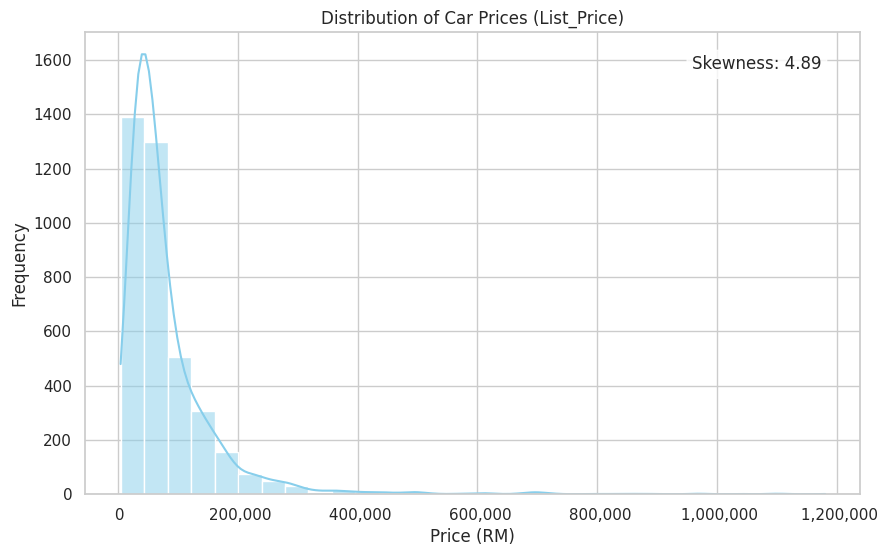

In [ ]:
# Univariate Analysis (The Price Skew)
# Before testing hypotheses, we must understand the target variable: Price.
# Goal: Identify if the price is skewed and requires transformation. Logic: Most cars in Malaysia are mass-market models, creating a "long tail" of luxury cars.
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# 1. Define the Currency Formatter
def currency_formatter(x, pos):
    return f' {x:,.0f}'

fmt = ticker.FuncFormatter(currency_formatter)

# 2. Calculate Skewness
price_skewness = df['Price'].skew()

# 3. Create the Plot
plt.figure(figsize=(10, 6))
sns.histplot(df['Price'], kde=True, bins=30, color='skyblue')

# Apply formatting to X-axis (since Price is on X here)
plt.gca().xaxis.set_major_formatter(fmt)

# 4. Add Skewness Annotation
# transform=plt.gca().transAxes ensures the text stays in the top-right corner
# regardless of the data scale (0.95, 0.95 = 95% from left, 95% from bottom)
plt.text(0.95, 0.95, f'Skewness: {price_skewness:.2f}',
         transform=plt.gca().transAxes,
         ha='right', va='top', fontsize=12,
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.title('Distribution of Car Prices (List_Price)')
plt.xlabel('Price (RM)')
plt.ylabel('Frequency')
plt.show()

**Summary**

Observation: Data is highly right-skewed (4.89), with the vast majority of cars priced under RM 80,000.

Action: Validates the need for Log-Transformation to prevent the model from being biased by rare luxury supercars.

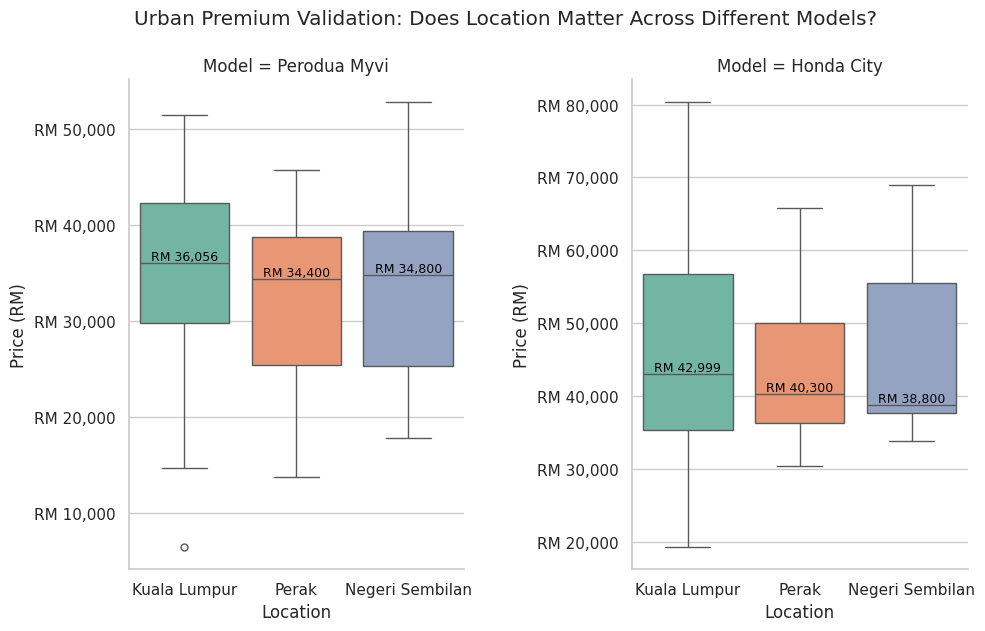

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker

# 1. Define the Currency Formatter (Reusing this for clean axes)
def currency_formatter(x, pos):
    return f'RM {x:,.0f}'
fmt = ticker.FuncFormatter(currency_formatter)

# 2. Select the Models and States you want to compare
target_models = ['Perodua Myvi', 'Honda City']
target_states = ['Kuala Lumpur', 'Perak', 'Negeri Sembilan']

# 3. Filter the data
df_multi = df[df['Model'].isin(target_models) & df['State'].isin(target_states)]

# 4. Create the Side-by-Side Boxplots
g = sns.catplot(data=df_multi, x='State', y='Price', col='Model',
                kind='box', sharey=False, hue='State', legend=False, palette='Set2', height=6, aspect=0.8)

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5)

# 5. Apply formatting to every subplot AND add median labels
for col_idx, ax in enumerate(g.axes.flat):
    ax.yaxis.set_major_formatter(fmt)
    ax.set_xlabel('Location')
    ax.set_ylabel('Price (RM)')

    # Get the current model name for this subplot
    current_model = g.col_names[col_idx]

    # Iterate through each state (box) to get its median and annotate
    for i, state in enumerate(target_states):
        median_price = df_multi[(df_multi['Model'] == current_model) & (df_multi['State'] == state)]['Price'].median()
        if pd.notna(median_price):
            ax.text(i, median_price, f'RM {median_price:,.0f}',
                    ha='center', va='bottom', fontsize=9, color='black')

# Add a main title at the top
g.fig.suptitle('Urban Premium Validation: Does Location Matter Across Different Models?', y=1.05)

plt.show()

**Summary**

Observation: Identical models (e.g. Perodua Myvi, Honda City) listed in Kuala Lumpur have 4.2% - 8.7% higher median prices than those in Perak and Negeri Sembilan.

/tmp/ipython-input-1930714137.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


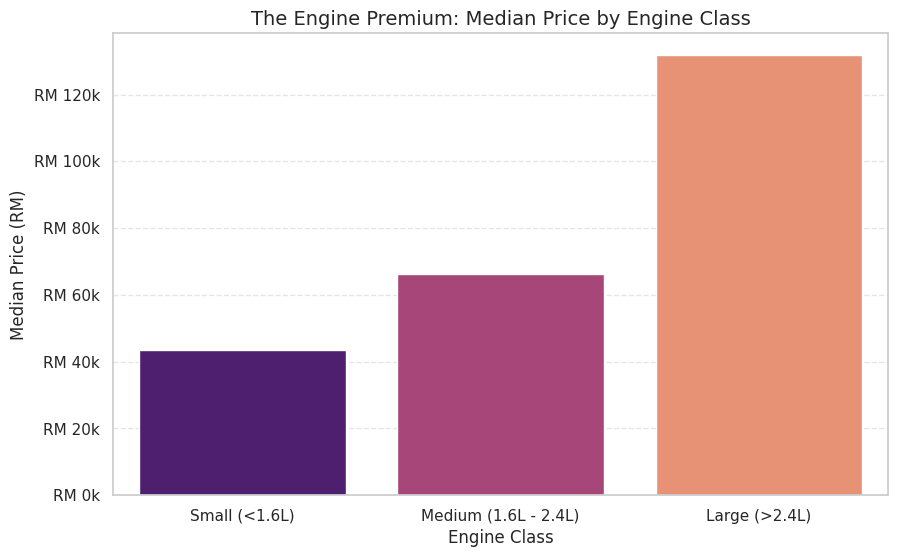

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import numpy as np

# --- LOGIC TO CREATE ENGINE CATEGORIES ---
def categorize_engine(liters):
    if liters < 1.6: return 'Small (<1.6L)'
    elif liters <= 2.4: return 'Medium (1.6L - 2.4L)'
    else: return 'Large (>2.4L)'

df_clean['Engine_Class'] = df_clean['Engine_L'].apply(categorize_engine)

# Define the logical order for the X-axis
engine_order = ['Small (<1.6L)', 'Medium (1.6L - 2.4L)', 'Large (>2.4L)']

# --- PLOT ---
plt.figure(figsize=(10, 6))

sns.barplot(
    data=df_clean,
    x='Engine_Class',
    y='Price',
    order=engine_order, # Ensures bars are sorted by size, not name
    palette='magma',
    estimator=np.median, # Change from mean to median
    errorbar=None # Clean look without error bars
)

plt.title('The Engine Premium: Median Price by Engine Class', fontsize=14) # Update title
plt.xlabel('Engine Class', fontsize=12)
plt.ylabel('Median Price (RM)', fontsize=12) # Update y-axis label
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Formatting Y-axis
formatter = ticker.FuncFormatter(lambda x, pos: f'RM {x/1000:.0f}k')
plt.gca().yaxis.set_major_formatter(formatter)

plt.show()

**Summary**

Observation: Vehicles with larger engines (>2.4L) consistently maintain a significantly higher median price floor compared to smaller capacity models (<1.6L).

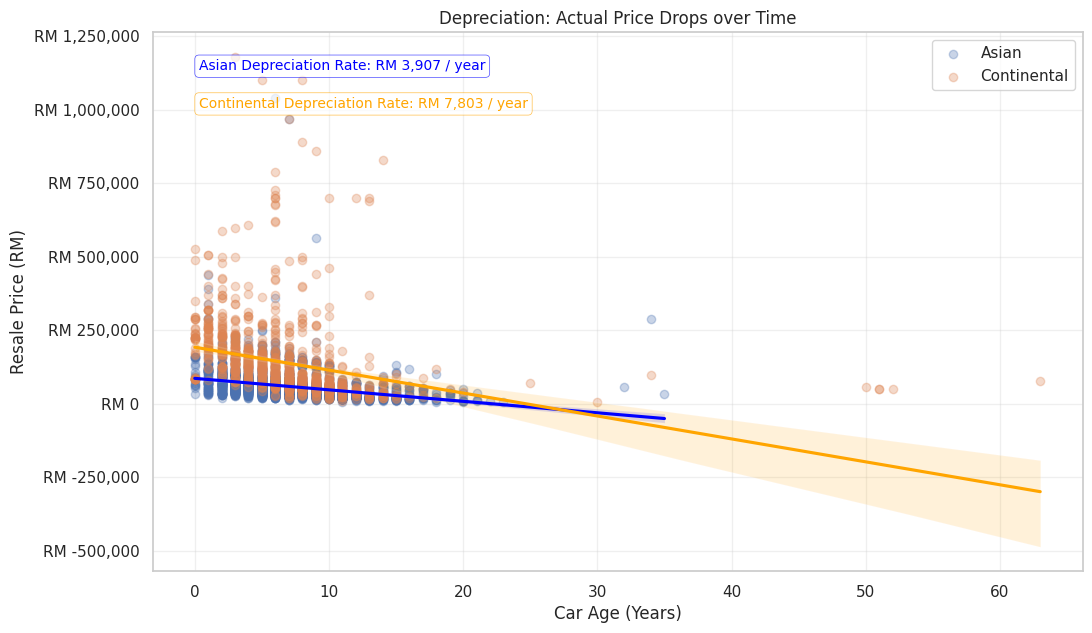

In [ ]:
# Bivariate Analysis
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
from scipy.stats import linregress

# 1. Define the Currency Formatter
def currency_formatter(x, pos):
    return f'RM {x:,.0f}'

fmt = ticker.FuncFormatter(currency_formatter)

plt.figure(figsize=(12, 7))

# Plot the regression lines
sns.regplot(data=df[df['Origin'] == 'Asian'], x='Car_Age', y='Price',
            label='Asian', scatter_kws={'alpha':0.3}, line_kws={'color':'blue'})
sns.regplot(data=df[df['Origin'] == 'Continental'], x='Car_Age', y='Price',
            label='Continental', scatter_kws={'alpha':0.3}, line_kws={'color':'orange'})

# Calculate slopes
df_asian = df[df['Origin'] == 'Asian']
slope_asian, _, _, _, _ = linregress(df_asian['Car_Age'], df_asian['Price'])

df_continental = df[df['Origin'] == 'Continental']
slope_continental, _, _, _, _ = linregress(df_continental['Car_Age'], df_continental['Price'])

# Add annotations to the plot (using absolute value for clearer depreciation rate)
plt.text(0.05, 0.95, f'Asian Depreciation Rate: RM {abs(slope_asian):,.0f} / year',
         transform=plt.gca().transAxes, ha='left', va='top', color='blue', fontsize=10,
         bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='blue', lw=0.5, alpha=0.7))
plt.text(0.05, 0.88, f'Continental Depreciation Rate: RM {abs(slope_continental):,.0f} / year',
         transform=plt.gca().transAxes, ha='left', va='top', color='orange', fontsize=10,
         bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='orange', lw=0.5, alpha=0.7))

# APPLY THE FIX: Format the Y-axis
plt.gca().yaxis.set_major_formatter(fmt)

plt.title('Depreciation: Actual Price Drops over Time')
plt.xlabel('Car Age (Years)')
plt.ylabel('Resale Price (RM)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

**Summary**

Observation: The regression line for Continental cars (Orange) is significantly steeper than for Asian cars (Blue).
Continental cars depreciate 99.72% faster than Asian cars.

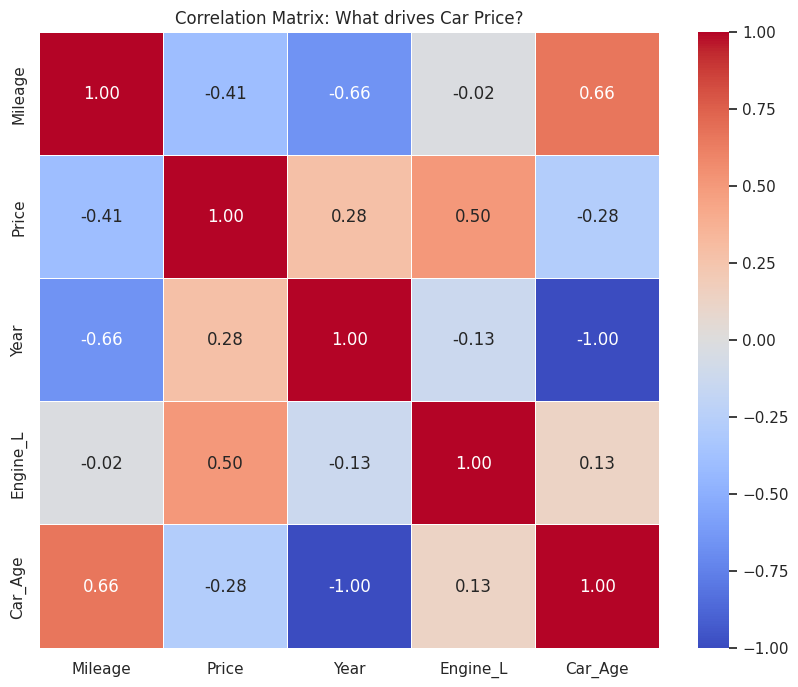

In [ ]:
# --- Correlation Matrix ---
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix: What drives Car Price?')
plt.show()

**Summary**

Engine Size (Engine_L) has the strongest positive correlation with Price (0.50).

Mileage has the strongest negative correlation with Price (-0.41).

Vehicle Age (Year / Car_Age) has a moderate correlation with Price (±0.28).

**Step 4: Feature Engineering**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# --- FIX: LOAD THE DATA INTO 'df_clean' FIRST ---
file_path = '/content/drive/My Drive/WIA1007/carlist_scraped_data_Cleaned.csv'
df_clean = pd.read_csv(file_path)

# --- STEP 1: ADVANCED FEATURE ENGINEERING ---
# 1. Create 'Log_Price'
df_clean['Log_Price'] = np.log1p(df_clean['Price'])

# 2. Create 'Annual_Mileage' (Usage Intensity)
df_clean['Annual_Mileage'] = df_clean['Mileage'] / df_clean['Car_Age'].replace(0, 1)

# 3. Create 'Has_Warranty' (Text Mining)
df_clean['Has_Warranty'] = df_clean['Description'].astype(str).str.lower().apply(
    lambda x: 1 if 'warranty' in x else 0
)

# 1. Verify the columns are in Python's memory
print("Columns in DataFrame:", df_clean.columns)

# 2. SAVE the changes to a new CSV file
df_clean.to_csv('/content/drive/My Drive/WIA1007/carlist_scraped_data_Cleaned_Engineered.csv', index=False)

print("Success! New file 'Malaysia_Resale_Carlist_Feature_Engineered.csv' created with new columns.")
# --- STEP 2: PREPARE DATA FOR TRAINING ---

# 1. Define Features (X) and Target (y)
features = [
    'Car_Age', 'Mileage', 'Annual_Mileage', 'Engine_L', 'Has_Warranty', # Numerical
    'Brand', 'Origin', 'State'                           # Categorical
]

X = df_clean[features]
y = df_clean['Log_Price'] # Target

# 2. One-Hot Encoding
X_encoded = pd.get_dummies(X, columns=['Brand', 'Origin', 'State'], drop_first=True)

# 3. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print("--- Data Ready for Modeling ---")
print(f"Training Features: {X_train.shape[1]} columns")
print(f"Training Samples:  {X_train.shape[0]} rows")

Columns in DataFrame: Index(['Description', 'List_Price', 'Model', 'Mileage', 'Gear_Type',
       'Location', 'Price', 'Year', 'State', 'Brand', 'Origin', 'Engine_L',
       'Car_Age', 'Log_Price', 'Annual_Mileage', 'Has_Warranty'],
      dtype='object')
Success! New file 'Malaysia_Resale_Carlist_Feature_Engineered.csv' created with new columns.
--- Data Ready for Modeling ---
Training Features: 60 columns
Training Samples:  3103 rows


**Step 5: Model Selection & Comparison**

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# --- 1. MODEL A: Linear Regression (The Baseline) ---
# Goal: Test if a simple straight-line equation works.
print("Training Model A: Linear Regression...")
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
y_pred_lr_log = lr.predict(X_test)
# Inverse Log (Convert back to RM)
y_pred_lr = np.expm1(y_pred_lr_log)
y_true = np.expm1(y_test)

# Evaluate
rmse_lr = np.sqrt(mean_squared_error(y_true, y_pred_lr))
r2_lr = r2_score(y_true, y_pred_lr)

print(f"--- Linear Regression Results ---")
print(f"RMSE: RM {rmse_lr:,.0f} (Avg Error)")
print(f"R2 Score: {r2_lr:.4f} (Accuracy: {r2_lr*100:.1f}%)")
print("-" * 30)


# --- 2. MODEL B: Random Forest (The Challenger) ---
# Goal: Test if a complex decision tree works better.
print("\nTraining Model B: Random Forest (This might take a moment)...")
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf_log = rf.predict(X_test)
# Inverse Log (Convert back to RM)
y_pred_rf = np.expm1(y_pred_rf_log)

# Evaluate
rmse_rf = np.sqrt(mean_squared_error(y_true, y_pred_rf))
r2_rf = r2_score(y_true, y_pred_rf)

print(f"--- Random Forest Results ---")
print(f"RMSE: RM {rmse_rf:,.0f} (Avg Error)")
print(f"R2 Score: {r2_rf:.4f} (Accuracy: {r2_rf*100:.1f}%)")
print("-" * 30)


# --- 3. THE VERDICT ---
print("\n=== 🏆 FINAL VERDICT ===")
if r2_rf > r2_lr:
    diff = rmse_lr - rmse_rf
    print(f"WINNER: Random Forest!")
    print(f"Why: It reduced the prediction error by RM {diff:,.0f} per car compared to the simple model.")
    print("Insight: Car depreciation is non-linear, so the advanced model captured it better.")
else:
    print(f"WINNER: Linear Regression!")
    print(f"Why: The data is simple enough that we don't need a complex AI.")

Training Model A: Linear Regression...
--- Linear Regression Results ---
RMSE: RM 55,123 (Avg Error)
R2 Score: 0.6754 (Accuracy: 67.5%)
------------------------------

Training Model B: Random Forest (This might take a moment)...
--- Random Forest Results ---
RMSE: RM 44,339 (Avg Error)
R2 Score: 0.7900 (Accuracy: 79.0%)
------------------------------

=== 🏆 FINAL VERDICT ===
WINNER: Random Forest!
Why: It reduced the prediction error by RM 10,784 per car compared to the simple model.
Insight: Car depreciation is non-linear, so the advanced model captured it better.


**Step 6: Modal Training**

Hyperparameter Tuning (Making the Winner Smarter)

In [ ]:
from sklearn.model_selection import GridSearchCV

# 1. Define the "Grid" of settings to test
# We will test 2 x 2 x 2 = 8 different combinations.
param_grid = {
    'n_estimators': [100, 200],       # Number of trees (More is usually better but slower)
    'max_depth': [None, 20],          # How deep can each tree go? (None = unlimited)
    'min_samples_split': [2, 5]       # Minimum cars needed to split a node
}

# 2. Initialize the Grid Search
# cv=3 means "Cross Validation": It splits the data 3 ways to ensure the result is consistent.
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=3, n_jobs=-1, verbose=2, scoring='r2')

# 3. Run the Search (This takes time!)
print("Tuning the model... (This might take 1-2 minutes)")
grid_search.fit(X_train, y_train)

# 4. Get the Best Results
best_rf = grid_search.best_estimator_
print("\n--- Tuning Complete ---")
print(f"Best Settings Found: {grid_search.best_params_}")

# 5. Evaluate the "Tuned" Model
y_pred_tuned_log = best_rf.predict(X_test)
y_pred_tuned = np.expm1(y_pred_tuned_log) # Convert back to RM

r2_tuned = r2_score(y_test, y_pred_tuned_log) # Compare Log vs Log for fairness
rmse_tuned = np.sqrt(mean_squared_error(np.expm1(y_test), y_pred_tuned))

print(f"\nFinal Accuracy (Tuned Random Forest):")
print(f"  R2 Score: {r2_tuned:.4f} ({r2_tuned*100:.2f}%)")
print(f"  RMSE: RM {rmse_tuned:,.0f}")

Tuning the model... (This might take 1-2 minutes)
Fitting 3 folds for each of 8 candidates, totalling 24 fits

--- Tuning Complete ---
Best Settings Found: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}

Final Accuracy (Tuned Random Forest):
  R2 Score: 0.8826 (88.26%)
  RMSE: RM 43,602


**Step 7: Final Deliverable**

Save the modal

In [ ]:
import joblib
import os
from google.colab import drive

# 1. Mount Google Drive (if not already mounted)
drive.mount('/content/drive')

# 2. Define your specific folder path
# This matches the folder you used for your CSV file
save_path = '/content/drive/My Drive/WIA1007/'

# Create the folder if it doesn't exist (safety check)
if not os.path.exists(save_path):
    os.makedirs(save_path)

# 3. Save the Model (The "Brain")
# Note: We combine the folder path + filename
joblib.dump(best_rf, save_path + 'my_car_price_model.pkl')

# 4. Save the Feature Names (The "Map")
model_columns = list(X_train.columns)
joblib.dump(model_columns, save_path + 'model_columns.pkl')

print(f"✅ Success! Files saved permanently to: {save_path}")
print("You can now see them in your Google Drive folder 'WIA1007'.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Success! Files saved permanently to: /content/drive/My Drive/WIA1007/
You can now see them in your Google Drive folder 'WIA1007'.


**Final Modal Accuracy**

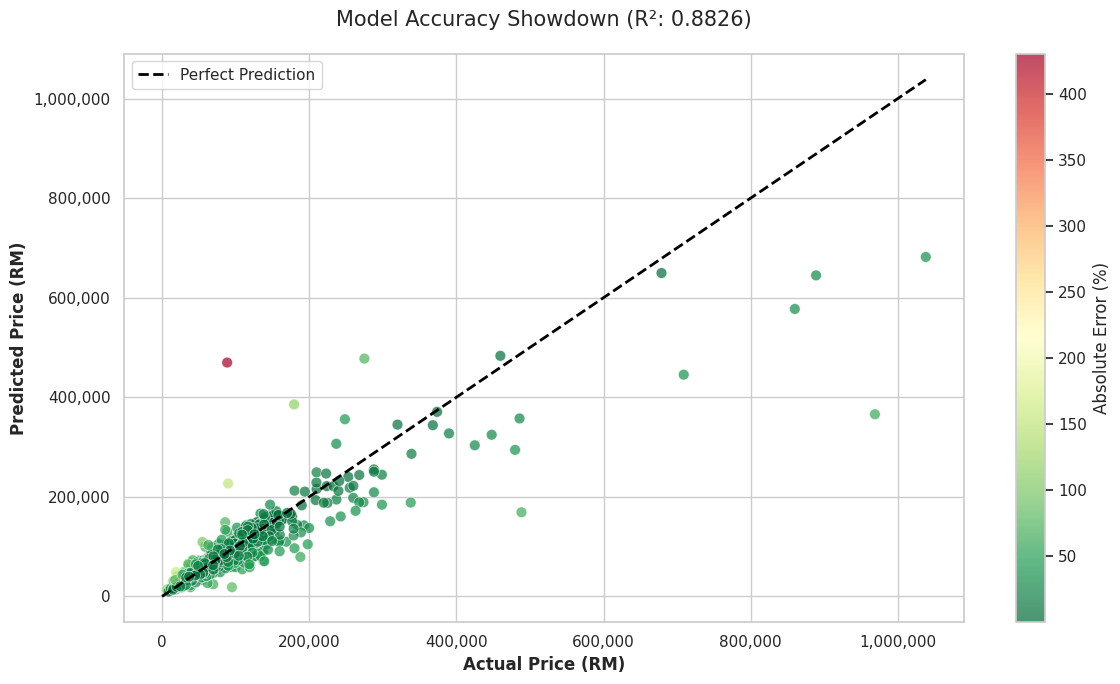

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.ticker as ticker

# Ensure y_true represents actual prices for comparison
y_true_actual = np.expm1(y_test)

# --- 1. Calculate the Error for Color Mapping ---
# We calculate the absolute percentage error to see where the model is "off"
# Use y_pred_tuned and y_true_actual
error_pct = np.abs((y_true_actual - y_pred_tuned) / y_true_actual) * 100

# --- 2. Create the Enhanced Plot ---
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")

# We use 'hue' to color the dots by their error percentage
# 'coolwarm' or 'RdYlGn_r' (Red-Yellow-Green) makes errors pop
scatter = plt.scatter(x=y_true_actual, y=y_pred_tuned,
                      c=error_pct, cmap='RdYlGn_r',
                      alpha=0.7, edgecolors='w', linewidth=0.5, s=60)

# Add the "Perfect Prediction" line
max_val = max(y_true_actual.max(), y_pred_tuned.max())
plt.plot([0, max_val], [0, max_val], color='black', linestyle='--', lw=2, label='Perfect Prediction')

# Add a Color Bar to explain the colors
cbar = plt.colorbar(scatter)
cbar.set_label('Absolute Error (%)', fontsize=12)

# --- 3. Labels and Formatting ---
plt.xlabel('Actual Price (RM)', fontsize=12, fontweight='bold')
plt.ylabel('Predicted Price (RM)', fontsize=12, fontweight='bold')
plt.title(f'Model Accuracy Showdown (R²: {r2_tuned:.4f})', fontsize=15, pad=20)
plt.legend(loc='upper left')

# Define the Currency Formatter
def currency_formatter(x, pos):
    return f'{x:,.0f}'
fmt = ticker.FuncFormatter(currency_formatter)

# Apply formatting to both X and Y axes
plt.gca().xaxis.set_major_formatter(fmt)
plt.gca().yaxis.set_major_formatter(fmt)


plt.tight_layout()
plt.show()



**VISUALIZING FEATURE IMPORTANCE**



--- Generating Feature Importance Plot ---


/tmp/ipython-input-1094341543.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_df, x='Importance', y='Feature', palette='viridis')


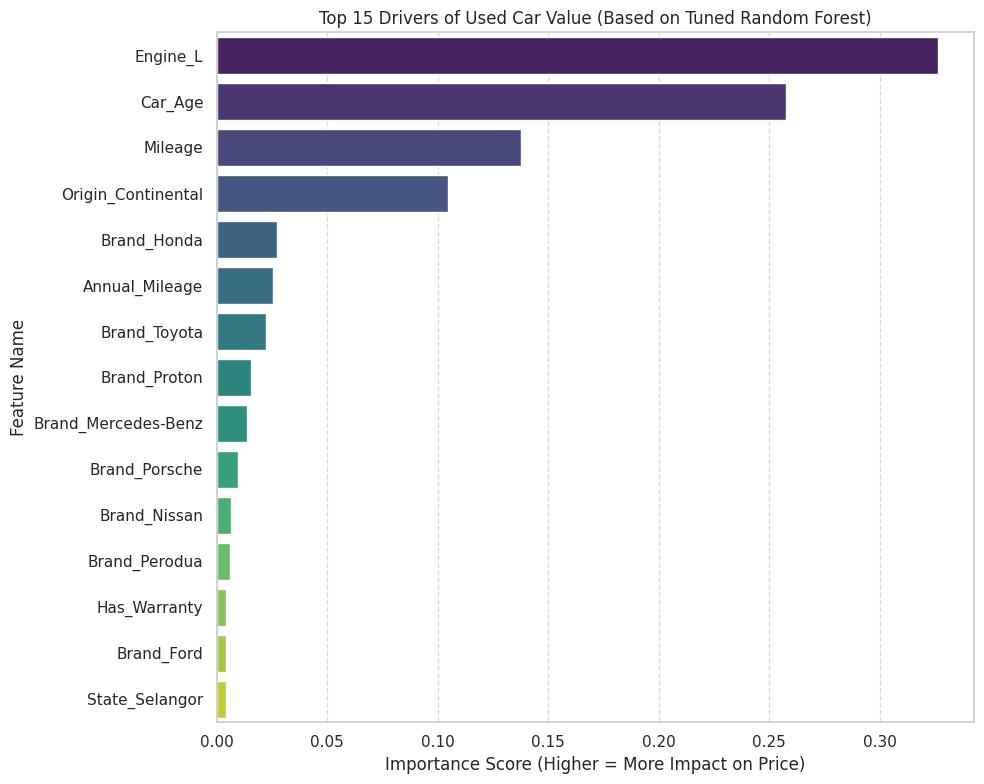


--- Top 5 Most Influential Features ---
           Feature  Importance
          Engine_L    0.326338
           Car_Age    0.257791
           Mileage    0.137670
Origin_Continental    0.104628
       Brand_Honda    0.027430


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- VISUALIZING FEATURE IMPORTANCE ---
print("--- Generating Feature Importance Plot ---")

# 1. Extract Importance Scores from the BEST model (Tuned)
importances = best_rf.feature_importances_
feature_names = X_train.columns

# 2. Create a DataFrame to organize the data
feature_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 3. Sort by Importance (Highest on top) and pick Top 15
feature_df = feature_df.sort_values(by='Importance', ascending=False).head(15)

# 4. Create the Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_df, x='Importance', y='Feature', palette='viridis')

# 5. Add Labels and Titles
plt.title("Top 15 Drivers of Used Car Value (Based on Tuned Random Forest)")
plt.xlabel("Importance Score (Higher = More Impact on Price)")
plt.ylabel("Feature Name")
plt.grid(axis='x', linestyle='--', alpha=0.7)

# 6. Show the plot
plt.tight_layout()
plt.show()

# 7. Print the exact numbers for your report
print("\n--- Top 5 Most Influential Features ---")
print(feature_df.head(5)[['Feature', 'Importance']].to_string(index=False))

Test Run

In [ ]:
import joblib
import pandas as pd
import numpy as np

# --- 1. SETUP THE PATH ---
# This points to the folder where we just saved your model
model_path = '/content/drive/My Drive/WIA1007/'

def predict_car_price(year, mileage, engine_l, brand, origin, state, is_warranty):
    # 2. Load the "Brain" and "Map" from Google Drive
    try:
        loaded_model = joblib.load(model_path + 'my_car_price_model.pkl')
        loaded_columns = joblib.load(model_path + 'model_columns.pkl')
    except FileNotFoundError:
        print(f"Error: Could not find files in {model_path}. Did you run the 'Save' code block?")
        return 0

    # 3. Process User Input (Calculations)
    current_year = 2022 # Reference year
    car_age = current_year - year
    # Prevent division by zero
    annual_mileage = mileage / (car_age if car_age > 0 else 1)
    has_warranty = 1 if is_warranty else 0

    # 4. Create a blank table with the exact columns the model expects
    input_data = pd.DataFrame(0, index=[0], columns=loaded_columns)

    # 5. Fill in the Numerical Values
    input_data['Car_Age'] = car_age
    input_data['Mileage'] = mileage
    input_data['Annual_Mileage'] = annual_mileage
    input_data['Engine_L'] = engine_l
    input_data['Has_Warranty'] = has_warranty

    # 6. Fill in the Categorical Values (One-Hot Encoding)
    # The logic: If "Brand_Honda" exists in the trained columns, set it to 1.
    if f"Brand_{brand}" in loaded_columns:
        input_data[f"Brand_{brand}"] = 1

    if f"Origin_{origin}" in loaded_columns:
        input_data[f"Origin_{origin}"] = 1

    if f"State_{state}" in loaded_columns:
        input_data[f"State_{state}"] = 1

    # 7. Predict!
    log_price_prediction = loaded_model.predict(input_data)[0]
    final_price = np.expm1(log_price_prediction) # Convert Log -> Real Money

    return final_price

# --- TEST YOUR MODEL HERE ---
# Example: 4-Year-Old Honda Civic
print("Testing prediction for a 2018 Honda Civic...")
my_prediction = predict_car_price(
    year=2018,
    mileage=60000,
    engine_l=1.8,
    brand='Honda',
    origin='Asian',
    state='Selangor',
    is_warranty=False
)

print(f"💰 Estimated Price: RM {my_prediction:,.2f}")

Testing prediction for a 2018 Honda Civic...
💰 Estimated Price: RM 68,454.04
